# Imports

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from lxml import etree

# Classes

In [29]:
class FitnessProperty :
    def __init__(self, node) :
        self.inverse = node.find('.//Inverse').text
        self.statistic_type = node.find('.//StatisticType').text
        self.weight = float(node.find('.//Weight').text)
        
    def to_string(self) :
        return f'Inverse: {self.inverse}, Statistic Type: {self.statistic_type}, Weight: {self.weight}'

class PartialValue :
    def __init__(self, node) :
        self.type = node.find('.//Type').text
        self.raw_value = float(node.find('.//RawValue').text)
        self.max_value = float(node.find('.//MaxValue').text)
        self.normalized_value = float(node.find('.//NormalizedValue').text)

    def to_string(self) :
        return f'Type: {self.type}, Raw Value: {self.raw_value}, Max Value: {self.max_value}, Normalized Value: {self.normalized_value}'

class Fitness :
    def __init__(self, node) :
        self.value = float(node.find('.//Value').text)
        
        self.partial_values = []
        
        partial_values = node.find('.//PartialValues')
        
        for partial_value in partial_values :
                self.partial_values.append(PartialValue(partial_value))

    def to_string(self) :
        header = f'Value: {self.value}'
        
        partial_values_string = '\nPartial Values: [\n'
        
        for partial_value in self.partial_values :
            partial_values_string += '\t' + partial_value.to_string() + '\n'
            
        partial_values_string += ']'
        
        return header + partial_values_string

In [30]:
class BehaviourGene :
    def __init__(self, node) :
        self.behaviour_type = node.find('.//BehaviourType').text

    def to_string(self) :
        return f'Behaviour Gene [Behaviour Type: {self.behaviour_type}]'
       
class WeaponGene :
    def __init__(self, node) :
        self.weapon_type = node.find('.//WeaponType').text
        
    def to_string(self) :
        return f'Weapon Gene [Weapon Type: {self.weapon_type}]'

In [31]:
class Trait :
    def __init__(self, node) :
        self.identifier = node[0].text
        self.amount = int(node[1].text)
        
    def to_string(self) :    
        return f'Identifier: {self.identifier}, Amount: {self.amount}'
        
class TraitsGene :
    def __init__(self, node) :
        self.chosen_trait = node.find('.//ChosenTrait').text
        self.mutation_added_trait = node.find('.//MutationAddedTrait').text
        self.mutation_removed_trait = node.find('.//MutationRemovedTrait').text
        
        self.traits = []
        
        traits = node.find('.//Traits')
        
        for trait in traits :
            self.traits.append(Trait(trait))
    
    def to_string(self) :
        header = f'TraitGene [Chosen Trait: {self.chosen_trait}, Mutation Added Trait: {self.mutation_added_trait}, Mutation Removed Trait: {self.mutation_removed_trait}'

        traits_string = '\n\tTraits: [\n'
        
        for trait in self.traits :
            traits_string += '\t\t' + trait.to_string() + '\n'
        
        traits_string += '\t\t]\n'
        
        return header + traits_string + '\t]'  

In [32]:
class Chromosome :
    def __init__(self, node) :
        self.genes = []

        genes = node.findall('.//Gene')

        for gene in genes :
            if (gene.items()[0][1] == 'BehaviourGene') :
                self.genes.append(BehaviourGene(gene))
            elif (gene.items()[0][1] == 'TraitsGene') :
                self.genes.append(TraitsGene(gene))
            elif (gene.items()[0][1] == 'WeaponGene') :
                self.genes.append(WeaponGene(gene))
        
    def to_string(self) :
        genes_string = 'Genes: [\n'
        
        for gene in self.genes :
            genes_string += '\t' + gene.to_string() + '\n'
        
        genes_string += ']\n'
        
        return genes_string

class Creature :
    def __init__(self, node) :
        self.id = node.find('.//Id').text
        self.generation = node.find('.//Generation').text
        self.fitness = Fitness(node.find('.//Fitness'))
        self.chromosome = Chromosome(node.find('.//Chromosome')) 
        self.is_dead = node.find('.//IsDead').text
        
        self.parents = []

        parents = node.find('.//Parents')
        
        for parent in parents :
            self.parents.append(parent.text)

        self.children = []
        
        children = node.find('.//Children')
        
        for child in children :
            self.children.append(child.text)        
        
    def to_string(self) :
        header = f'Id: {self.id}, Generation: {self.generation}'
        
        parents_string = f'\nParents: {self.parents}'
        
        children_string = f'\nChildren: {self.children}'
        
        fitness_string = '\n' + self.fitness.to_string()
        
        chromosome_string = '\n' + self.chromosome.to_string()
        
        return header + parents_string + children_string + fitness_string + chromosome_string

In [33]:
class TraitWeight :
    def __init__(self, node) :
        self.identifier = node[0].text
        self.weight = float(node[1].text)

class Generation :
    def __init__(self, node) :
        self.number = int(node.find('.//Number').text)
        self.total_fitness = float(node.find('.//GenerationFitness').text)

        self.creatures = []
        
        creatures = node.find('.//Creatures')
        
        for creature in creatures :
            self.creatures.append(Creature(creature))

        self.average_fitness = float(self.total_fitness) / len(self.creatures)
        
        fitness_values = [creature.fitness.value for creature in self.creatures]
        
        self.min_fitness, self.max_fitness = min(fitness_values), max(fitness_values)
        
        self.trait_weights = []
        
        trait_weights = node.find('.//TraitWeights')
        
        for trait_weight in trait_weights :
            self.trait_weights.append(TraitWeight(trait_weight))
            
    def to_string(self) : 
        header = f'Number: {self.number}, Total Fitness: {self.total_fitness}'
        
        creatures_string = '\nCreatures: [\n'
        
        for creature in self.creatures :
            creatures_string += '\t' + creature.to_string() + '\n'
            
        creatures_string += ']'
        
        return header + creatures_string

In [34]:
class GeneticAlgorithmData :
    def __init__(self, node) :
        self.team = node.find('.//Team').text
        self.trait_selection_amount = node.find('.//TraitSelectionAmount').text
        self.trait_selection_dumbness = node.find('.//TraitSelectionDumbness').text
        
        self.fitness_properties = []
        
        fitness_properties = node.find('.//FitnessProperties')
        
        for fitness_property in fitness_properties :
            self.fitness_properties.append(FitnessProperty(fitness_property))
        
        self.generations = []
        
        generations = node.find('.//Generations')
        
        for generation in generations :
            self.generations.append(Generation(generation))
            
    def to_string(self) :
        header = f'Team: {self.team},'\
                f' Trait Selection Amount: {self.trait_selection_amount},'\
                f' Trait Selection Dumbness: {self.trait_selection_dumbness}'

        fitness_property_string = '\nFitness Properties: [\n'
        
        for fitness_property in self.fitness_properties :
            fitness_property_string += '\t' + fitness_property.to_string() + '\n'
                
        fitness_property_string += ']'
                
        generations_string = '\nGenerations: [\n'
        
        for generation in self.generations :
            generations_string += '\t' + generation.to_string() + '\n'
            
        generations_string += ']'
        
        return header + fitness_property_string + generations_string

# Data Setup

In [35]:
def get_ga_data(file_path) :
    tree = etree.parse(file_path)
    root = tree.getroot()
    data = GeneticAlgorithmData(root)
    return data

def get_generations_data(ga_data) :
    number = []
    total_fitness = []
    average_fitness = []
    
    for generation in ga_data.generations :
        number.append(generation.number)
        total_fitness.append(generation.total_fitness)
        average_fitness.append(generation.average_fitness)
        
    return number, total_fitness, average_fitness 

team1_data = get_ga_data('./team1.xml')
team2_data = get_ga_data('./team2.xml')

generations = np.arange(len(team1_data.generations)) + 1
creature_count = len(team1_data.generations[0].creatures)

# Plot

## Fitness

Properties

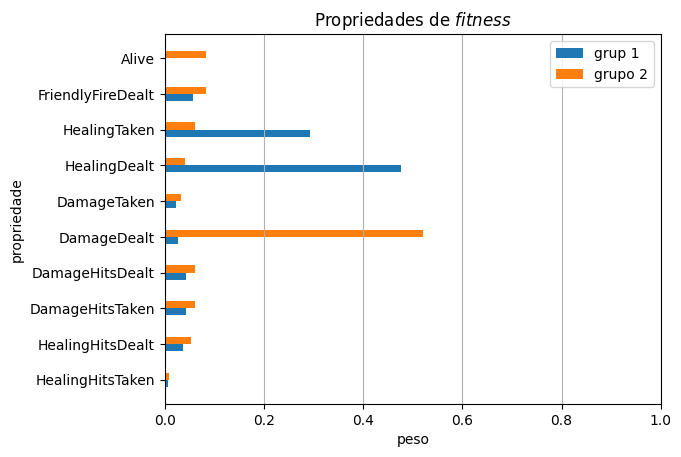

In [36]:
def plot_fitness_properties() :
    fig, ax = plt.subplots()
    
    plt.xlim(0, 1)
    
    properties = [fitness_property.statistic_type for fitness_property in team1_data.fitness_properties]
    
    team1_weights = [fitness_property.weight for fitness_property in team1_data.fitness_properties]
    team2_weights = [fitness_property.weight for fitness_property in team2_data.fitness_properties]
    
    index = np.arange(len(properties))
    
    bar_height = 0.2
    
    ax.barh(index, team1_weights, bar_height, label = 'grupo 1', align = 'center')
    ax.barh(index + bar_height, team2_weights, bar_height, label = 'grupo 2', align = 'center')
    
    ax.set_yticks(index + bar_height / 2)
    ax.set_yticklabels(properties)
    
    ax.set_title('Propriedades de $\it{fitness}$')
    ax.set_xlabel('peso')
    ax.set_ylabel('propriedade')
    
    plt.grid(axis = 'x')
    plt.legend()
    plt.show()

plot_fitness_properties()

Average fitness per generation

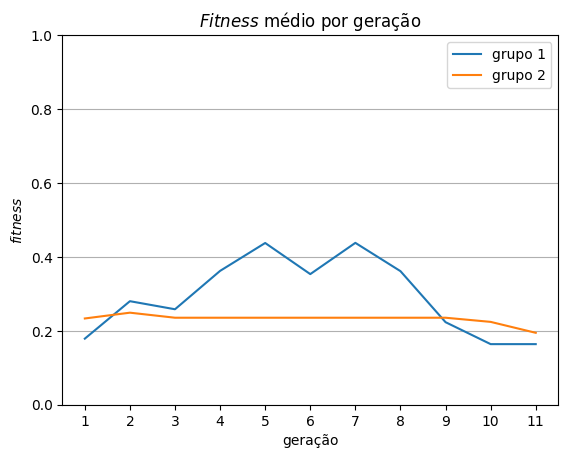

In [37]:
def plot_average_fitness_per_generation(ga_data, label) :
    average_fitness = [generation.average_fitness for generation in ga_data.generations]

    plt.plot(generations, average_fitness, label = label)

fig, ax = plt.subplots()

plt.title("$\it{Fitness}$ médio por geração")
plt.xlabel('geração')
plt.ylabel('$\it{fitness}$')

ax.set_xticks(generations)

plt.ylim(0, 1)

plt.grid(axis = 'y')

plot_average_fitness_per_generation(team1_data, 'grupo 1')
plot_average_fitness_per_generation(team2_data, 'grupo 2')

plt.legend()
plt.show()

Total fitness per generation

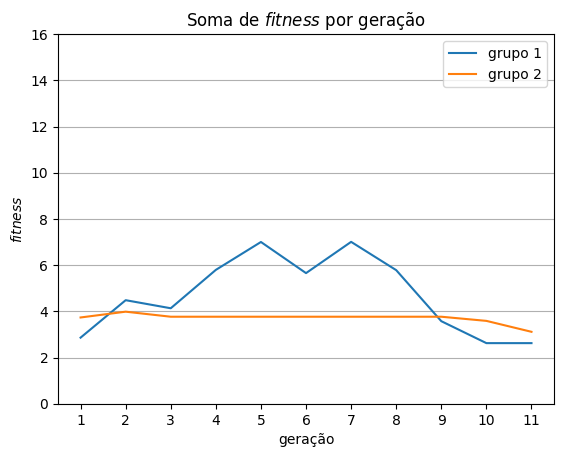

In [38]:
def plot_total_fitness_per_generation(ga_data, label) :
    total_fitness = [generation.total_fitness for generation in ga_data.generations]
    plt.plot(generations, total_fitness, label = label)

fig, ax = plt.subplots()

plt.title('Soma de $\it{fitness}$ por geração')

plt.xlabel('geração')
plt.ylabel('$\it{fitness}$')

ax.set_xticks(generations)

plt.ylim(0, creature_count)

plot_total_fitness_per_generation(team1_data, 'grupo 1')
plot_total_fitness_per_generation(team2_data, 'grupo 2')

plt.grid(axis = 'y')

plt.legend()
plt.show()

Minimum and maximum fitness per generation

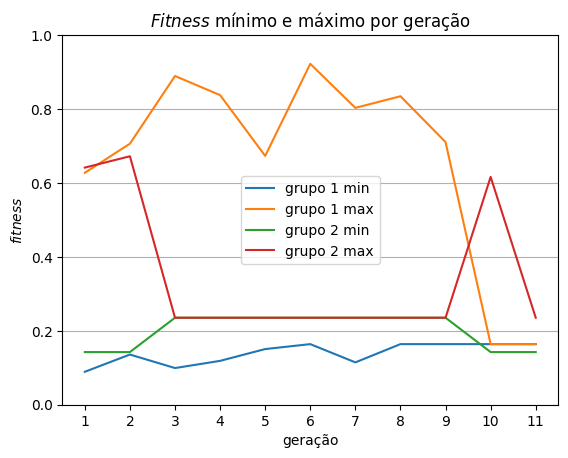

In [39]:
def plot_min_max_fitness_per_generation(ga_data, label) :
    min_fitness = []
    max_fitness = []
    
    for generation in ga_data.generations :
        min_fitness.append(generation.min_fitness)
        max_fitness.append(generation.max_fitness)

    plt.plot(generations, min_fitness, label = label + ' min')
    plt.plot(generations, max_fitness, label = label + ' max')

fig, ax = plt.subplots()

plt.title('$\it{Fitness}$ mínimo e máximo por geração')

plt.xlabel('geração')
plt.ylabel('$\it{fitness}$')

ax.set_xticks(generations)

plt.ylim(0, 1)

plt.grid(axis = 'y')

plot_min_max_fitness_per_generation(team1_data, 'grupo 1')
plot_min_max_fitness_per_generation(team2_data, 'grupo 2')

plt.legend()
plt.show()

## Statistics

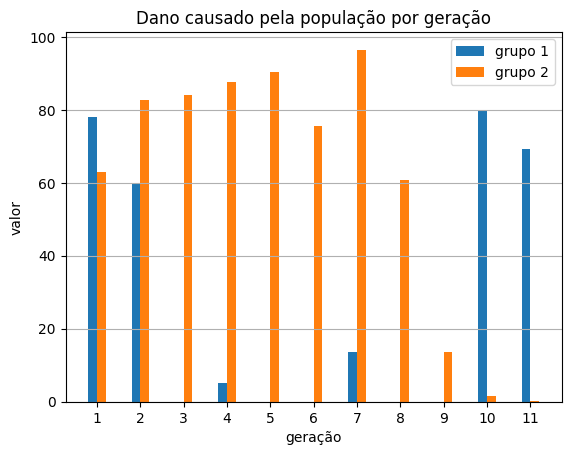

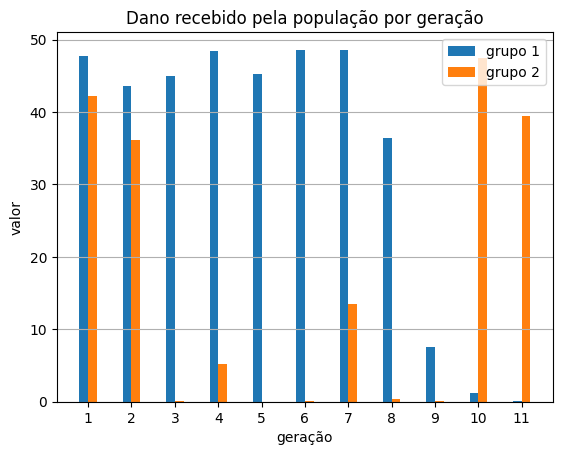

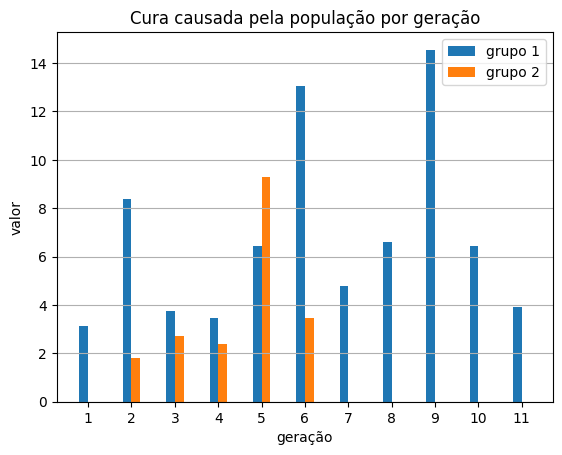

In [40]:
def get_statistic_values_per_generation(statistic, ga_data) :
    values = []
    
    for generation in ga_data.generations :
        value = 0
        
        for creature in generation.creatures :
            for partial_value in creature.fitness.partial_values :
                if partial_value.type == statistic :
                    value += partial_value.raw_value
                    continue
                    
        values.append(value)
        
    return values

def plot_statistic_value_per_generation(statistic, title) :
    fig, ax = plt.subplots()
    
    bar_width = 0.2
    
    team1_values = get_statistic_values_per_generation(statistic, team1_data)
    team2_values = get_statistic_values_per_generation(statistic, team2_data)
    
    index = np.arange(len(team1_values))
    
    ax.bar(index, team1_values, bar_width, label = 'grupo 1')
    ax.bar(index + bar_width, team2_values, bar_width, label = 'grupo 2')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(generations)
    
    ax.set_title(title + ' pela população por geração')
    ax.set_xlabel('geração')
    ax.set_ylabel('valor')
    
    plt.grid(axis = 'y')
    
    plt.legend()
    plt.show()
    
plot_statistic_value_per_generation('DamageDealt', 'Dano causado')
plot_statistic_value_per_generation('DamageTaken', 'Dano recebido')
plot_statistic_value_per_generation('HealingDealt', 'Cura causada')

## Weapons

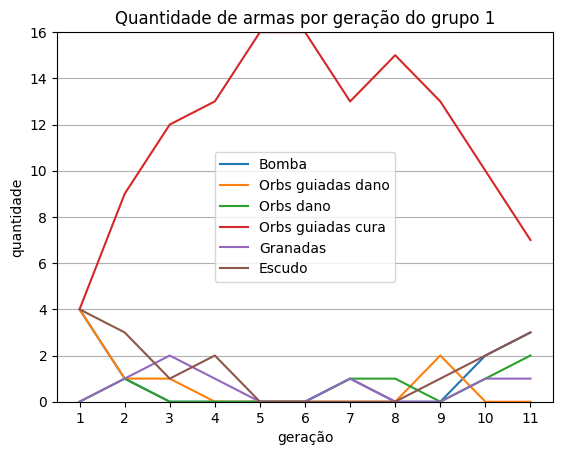

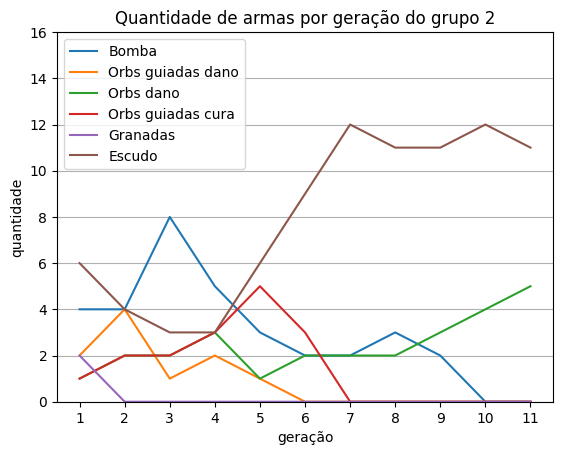

In [41]:
def get_weapon_usage_per_generation(ga_data, weapon) :
    values = []
    
    for generation in ga_data.generations :
        value = 0
        
        for creature in generation.creatures :
            for gene in creature.chromosome.genes :
                if isinstance(gene, WeaponGene) :
                    if (gene.weapon_type == weapon) :
                        value += 1
                        break       
                    
        values.append(value)
            
    return values

def plot_weapon_usage(ga_data, label) :
    fig, ax = plt.subplots()
    
    plt.plot(generations, get_weapon_usage_per_generation(ga_data, 'Nuke'), label = 'Bomba')
    plt.plot(generations, get_weapon_usage_per_generation(ga_data, 'DamageOrbs'), label = 'Orbs guiadas dano')
    plt.plot(generations, get_weapon_usage_per_generation(ga_data, 'OrbLauncher'), label = 'Orbs dano')
    plt.plot(generations, get_weapon_usage_per_generation(ga_data, 'HealingOrbs'), label = 'Orbs guiadas cura')
    plt.plot(generations, get_weapon_usage_per_generation(ga_data, 'GrenadeLauncher'), label = 'Granadas')
    plt.plot(generations, get_weapon_usage_per_generation(ga_data, 'ShieldDeployer'), label = 'Escudo')
    
    plt.ylim(0, creature_count)
    
    ax.set_xticks(generations)
    
    ax.set_xlabel('geração')
    ax.set_ylabel('quantidade')
    
    ax.set_title('Quantidade de armas por geração do ' + label)
    
    plt.grid(axis = 'y')
    
    plt.legend()
    plt.show()
    
plot_weapon_usage(team1_data, 'grupo 1')
plot_weapon_usage(team2_data, 'grupo 2')

## Behaviours

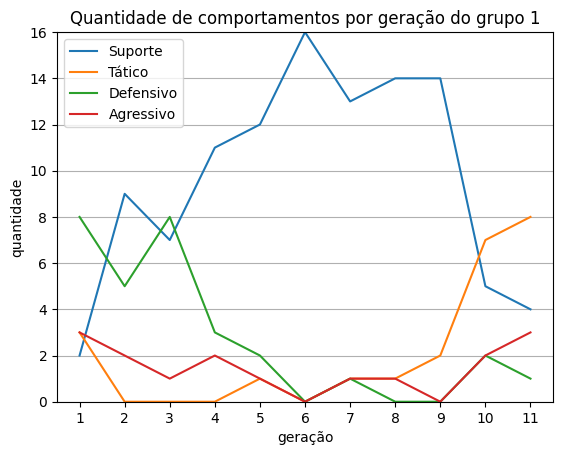

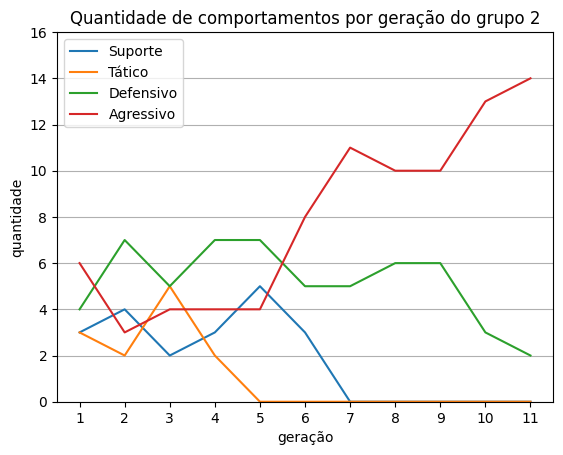

In [42]:
def get_behaviour_usage_per_generation(ga_data, behaviour) :
    values = []
    
    for generation in ga_data.generations :
        value = 0
        
        for creature in generation.creatures :
            for gene in creature.chromosome.genes :
                if isinstance(gene, BehaviourGene) :
                    if (gene.behaviour_type == behaviour) :
                        value += 1
                        break       
                    
        values.append(value)
            
    return values

def plot_behaviour_usage(ga_data, label) :
    fig, ax = plt.subplots()
    
    plt.plot(generations, get_behaviour_usage_per_generation(ga_data, 'Support'), label = 'Suporte')
    plt.plot(generations, get_behaviour_usage_per_generation(ga_data, 'Tactical'), label = 'Tático')
    plt.plot(generations, get_behaviour_usage_per_generation(ga_data, 'Defensive'), label = 'Defensivo')
    plt.plot(generations, get_behaviour_usage_per_generation(ga_data, 'Reckless'), label = 'Agressivo')
    
    plt.ylim(0, creature_count)
    
    ax.set_xticks(generations)
    
    ax.set_xlabel('geração')
    ax.set_ylabel('quantidade')
    
    ax.set_title('Quantidade de comportamentos por geração do ' + label)
    
    plt.grid(axis = 'y')
    plt.legend()
    plt.show()
    
plot_behaviour_usage(team1_data, 'grupo 1')
plot_behaviour_usage(team2_data, 'grupo 2')

## Traits

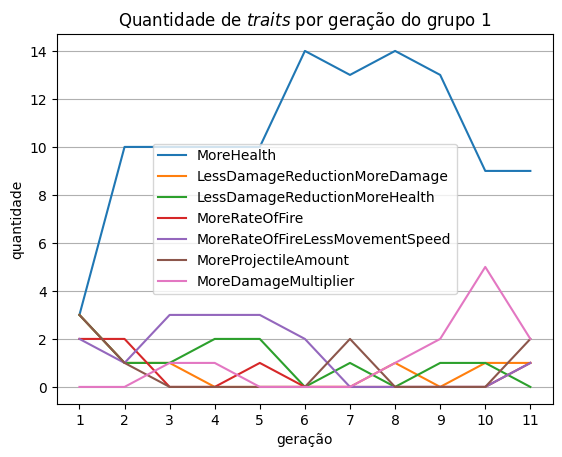

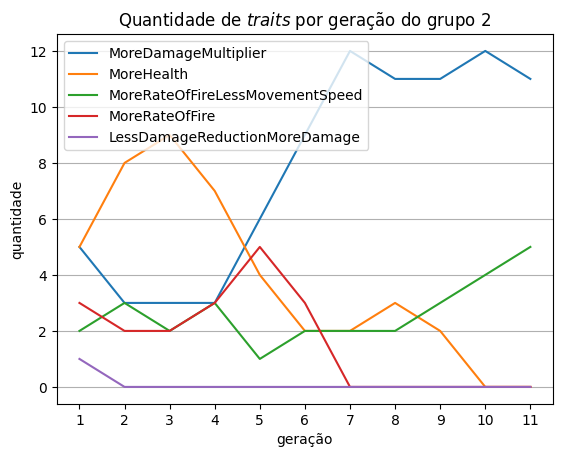

In [43]:
def get_traits_usage_per_generation(ga_data) :
    traits_all = dict()
    
    for generation in ga_data.generations :
        traits_temp = dict()
        
        for creature in generation.creatures :
            for gene in creature.chromosome.genes :
                if isinstance(gene, TraitsGene) :
                    for trait in gene.traits :
                        if trait.identifier not in traits_temp :
                            traits_temp[trait.identifier] = trait.amount
                        else :
                            traits_temp[trait.identifier] += trait.amount

        aux_len = -1                            
        for identifier, amount in traits_temp.items() :            
            if identifier not in traits_all :
                traits_all[identifier] = []
                
            if aux_len == -1 :
                aux_len = len(traits_all[identifier])

            traits_all[identifier].append(amount)
            traits_temp[identifier] = 0

            if aux_len < len(traits_all[identifier]) :
                aux_len = len(traits_all[identifier])

            if len(traits_all[identifier]) < aux_len :
                diff = aux_len - len(traits_all[identifier])
                
                for i in range(0, diff) :
                    traits_all[identifier].insert(0, 0)
            
        for identifier, amount in traits_all.items() :
            if (identifier not in traits_temp) :
                traits_all[identifier].append(0)
        
    return traits_all

def plot_trait_usage(ga_data, label) :
    fig, ax = plt.subplots()
    
    traits = get_traits_usage_per_generation(ga_data)
    
    for identifier, values in traits.items() :
        plt.plot(generations, values, label = identifier)    
    
    ax.set_xticks(generations)
    
    ax.set_xlabel('geração')
    ax.set_ylabel('quantidade')
    
    ax.set_title('Quantidade de $\it{traits}$ por geração do ' + label)
    
    plt.grid(axis = 'y')
    
    plt.legend()
    plt.show()
    
plot_trait_usage(team1_data, 'grupo 1')
plot_trait_usage(team2_data, 'grupo 2')

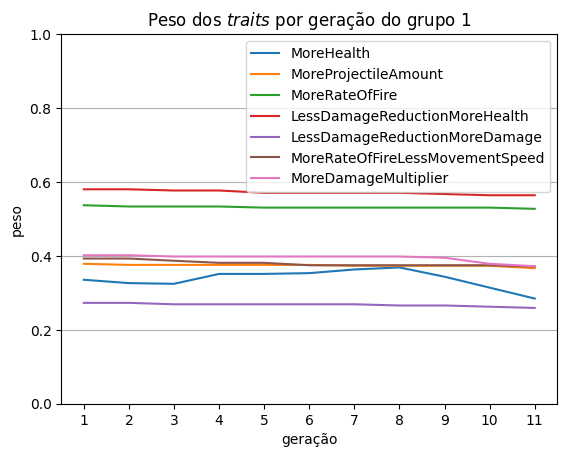

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


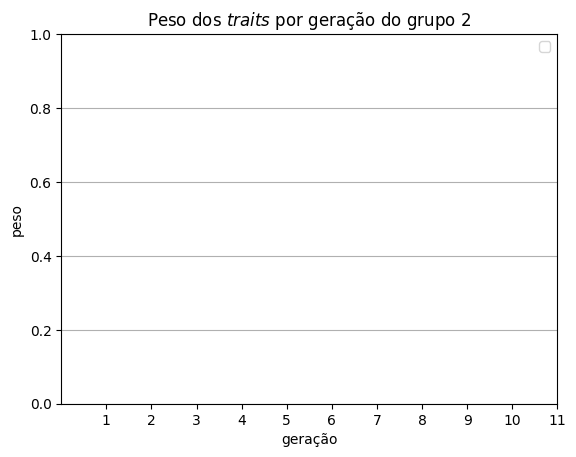

In [44]:
def get_traits_weight_per_generation(ga_data) :
    weights_all = dict()
    
    for generation in ga_data.generations :
        weights_temp = dict()
        
        for trait_weight in generation.trait_weights :
            weights_temp[trait_weight.identifier] = trait_weight.weight

        aux_len = -1                            
        for identifier, weight in weights_temp.items() :            
            if identifier not in weights_all :
                weights_all[identifier] = []
                
            if aux_len == -1 :
                aux_len = len(weights_all[identifier])

            weights_all[identifier].append(weight)
            weights_temp[identifier] = 0

            if aux_len < len(weights_all[identifier]) :
                aux_len = len(weights_all[identifier])

            if len(weights_all[identifier]) < aux_len :
                diff = aux_len - len(weights_all[identifier])
                
                for i in range(0, diff) :
                    weights_all[identifier].insert(0, 0.5)
            
        for identifier, weight in weights_all.items() :
            if (identifier not in weights_temp) :
                weights_all[identifier].append(0.5)
    
    if (len(ga_data.generations[0].trait_weights) == 0) :
        for identifier, _ in weights_all.items() :        
            weights_all[identifier].insert(0, 0.5)
            
    return weights_all

def plot_trait_weight_per_generation(ga_data, label) :
    fig, ax = plt.subplots()
    
    traits = get_traits_weight_per_generation(ga_data)
    
    for identifier, values in traits.items() :
        plt.plot(generations, values, label = identifier)    
    
    ax.set_xticks(generations)
    
    ax.set_xlabel('geração')
    ax.set_ylabel('peso')
    
    ax.set_title('Peso dos $\it{traits}$ por geração do ' + label)
    
    plt.grid(axis = 'y')
    
    plt.ylim(0, 1)
    
    plt.legend()
    plt.show()
    
plot_trait_weight_per_generation(team1_data, 'grupo 1')
plot_trait_weight_per_generation(team2_data, 'grupo 2')

## Overview

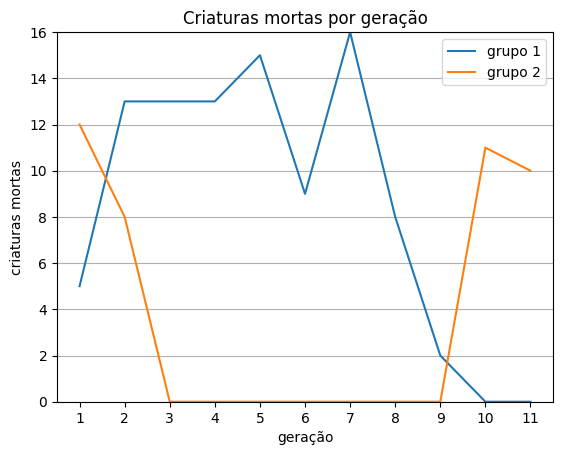

In [45]:
def plot_creatures_killed(ga_data, label) :
    creatures_killed = []
    
    for generation in ga_data.generations :
        amount = 0
        
        for creature in generation.creatures :
            if creature.is_dead == 'true':
                amount += 1

        creatures_killed.append(amount)
    
    plt.plot(generations, creatures_killed, label = label)

fig, ax = plt.subplots()

ax.set_xlabel('geração')
ax.set_ylabel('criaturas mortas')
ax.set_title('Criaturas mortas por geração')

plt.grid(axis = 'y')

plt.ylim(0, creature_count)

ax.set_xticks(generations)
    
plot_creatures_killed(team1_data, 'grupo 1')
plot_creatures_killed(team2_data, 'grupo 2')

plt.legend()
plt.show()